In [1]:
%env CLEARML_WEB_HOST=https://app.ml.leta-service.ru
%env CLEARML_API_HOST=https://api.ml.leta-service.ru
%env CLEARML_FILES_HOST=https://files.ml.leta-service.ru
%env CLEARML_API_ACCESS_KEY=BR7FW5BTCV2W3DMOFBKV
%env CLEARML_API_SECRET_KEY=t0bXH12vya5KbEMSRz0KoxcHCQ4ooI8RnWfaFomwsqvu47NISb

env: CLEARML_WEB_HOST=https://app.ml.leta-service.ru
env: CLEARML_API_HOST=https://api.ml.leta-service.ru
env: CLEARML_FILES_HOST=https://files.ml.leta-service.ru
env: CLEARML_API_ACCESS_KEY=BR7FW5BTCV2W3DMOFBKV
env: CLEARML_API_SECRET_KEY=t0bXH12vya5KbEMSRz0KoxcHCQ4ooI8RnWfaFomwsqvu47NISb


In [2]:
# Инициализация проекта ClearML
from clearml import Task
# task.close()
task = Task.init(project_name='uii', task_name='760')

ClearML Task: overwriting (reusing) task id=7793cfa0aa624f42a4b601e7aebf80aa
2023-06-06 13:03:19,669 - clearml.Task - INFO - Storing jupyter notebook directly as code
2023-06-06 13:03:19,673 - clearml.Repository Detection - WARNING - Can't get url information for git repo in /home/dev/projects/uii
2023-06-06 13:03:19,678 - clearml.Repository Detection - WARNING - Can't get branch information for git repo in /home/dev/projects/uii
2023-06-06 13:03:19,683 - clearml.Repository Detection - WARNING - Can't get commit information for git repo in /home/dev/projects/uii
ClearML results page: https://app.ml.leta-service.ru/projects/94402a0639ff4022a520e378e4e8aab4/experiments/7793cfa0aa624f42a4b601e7aebf80aa/output/log
2023-06-06 13:03:19,715 - clearml.Repository Detection - WARNING - Can't get diff information for git repo in /home/dev/projects/uii


ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [3]:
import tensorflow as tf

# Последовательная модель НС
from tensorflow.keras.models import Sequential  

# Основные слои
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization 

# Утилиты для to_categorical()
from tensorflow.keras import utils   

# Алгоритмы оптимизации для обучения модели
from tensorflow.keras.optimizers import Adam, Adadelta 

# Библиотека для работы с массивами
import numpy as np 

# Библиотека для работы с таблицами
import pandas as pd     

# Отрисовка графиков
import matplotlib.pyplot as plt     

# Связь с google-диском
# from google.colab import files   

# Предварительная обработка данных
from sklearn import preprocessing        

# Разделение данных на выборки
from sklearn.model_selection import train_test_split    

# Для загрузки датасета
from keras.datasets import fashion_mnist                   

# Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline

2023-06-06 13:03:20.322677: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-06 13:03:20.351513: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 13:03:21.196632: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### База: одежда, обувь и аксессуары
- Датасет состоит из набора изображений одежды, обуви, аксессуаров и их классов.
- Изображения одного вида хранятся в numpy-массиве **(28, 28)** - **x_train, x_test**.
- База содержит **10** классов: (Футболка, Брюки, Пуловер, Платье, Пальто, Сандалии/Босоножки, Рубашка, Кроссовки, Сумочка, Ботильоны) - **y_train, y_test**.
- Примеров: train - **60000**, test - **10000**.

In [4]:
# Загрузка датасета
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()   

# Вывод размерностей выборок

print('Размер x_train:',x_train.shape)                             
print('Размер y_train:',y_train.shape)
print('Размер x_test:',x_test.shape)
print('Размер y_test:',y_test.shape)

Размер x_train: (60000, 28, 28)
Размер y_train: (60000,)
Размер x_test: (10000, 28, 28)
Размер y_test: (10000,)


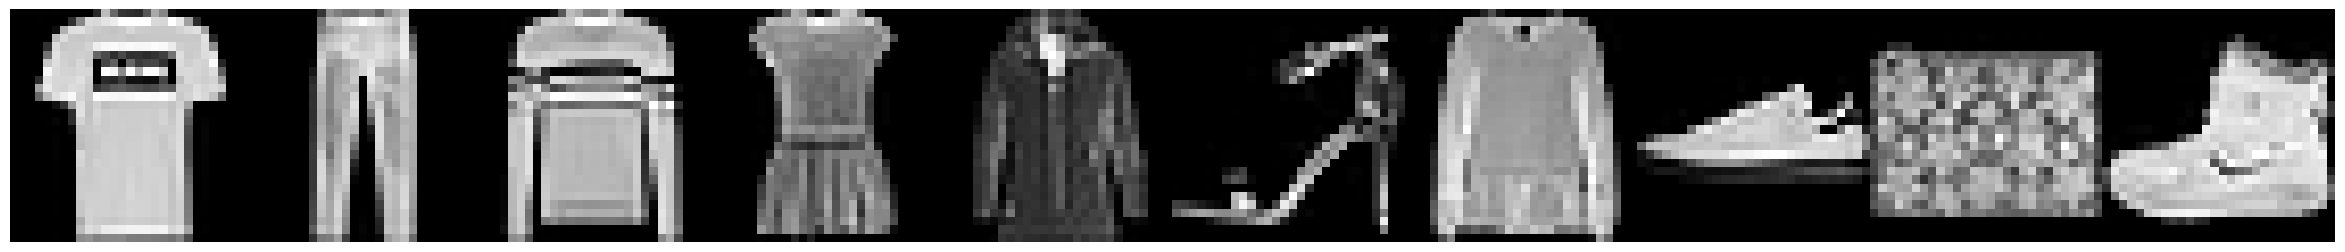

In [5]:
# Выбор 1 изображения каждого класса
imgs = np.array([x_train[y_train==i][0] for i in range(10)])

# Соединение изображения в одну линию
imgs = np.concatenate(imgs, axis=1)  

# Создание поля для изображения
plt.figure(figsize=(30, 6))   

# Отрисовка итогового изображения
plt.imshow(imgs, cmap='gray')    

# Без сетки
plt.grid(False) 

# Без осей
plt.axis('off')  

# Вывод результата
plt.show() 

In [6]:
# Константы
RESULTS = [] # собираем результаты тестов
CLASS_COUNT = 10 # кол-во классов товаров
VAL_SPLIT = 1/6 # доля проверочной выборки

In [7]:
# Вспомогательные функции

# добавление результата эксперимента
def add_result(result, comment):
  result.update({'comment': comment})
  RESULTS.append(result)

# получение результатов экспериментов
def get_results():
  return pd.DataFrame(RESULTS)

# функция компиляции модели, обучения, тестирования и вывода графиков (опционально)
def compile_train_eval(model, title, batch_size=32, epochs=30, loss='categorical_crossentropy', optimizer='adam', show_plots=True, verbose=0):
  # компиляция модели с заданными параметрами
  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

  # обучение с сохранением истории
  if verbose:
    print(f'Training {title}...')
  history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose, shuffle=True, validation_split=VAL_SPLIT)

  (train_acc, # последнее значение точноcти на обучающей выборке
   train_loss, # последнее значение потерь на обучающей выборке
   val_acc, # последнее значение точноcти на проверочной выборке
   val_loss # последнее значение потерь на проверочной выборке 
  ) = [round(history.history[x][-1], 2) for x in ['accuracy', 'loss', 'val_accuracy', 'val_loss']]
  
  # тестирование на тестовой выборке
  if verbose:
    print(f'Evaluating {title}...')
  test_loss, test_acc = [round(x, 2) for x in model.evaluate(x_test, y_test, verbose=verbose)]

  if show_plots:
    # вывод графиков обучения
    fig = plt.figure(figsize=(20, 6))
    fig.suptitle(f'Model: {title}', fontsize=20)
    # точности
    plt.subplot(1, 2, 1)
    plt.title(f'Accuracy')
    plt.plot(history.history['accuracy'], label=f'train_accuracy ({train_acc})')
    plt.plot(history.history['val_accuracy'], label=f'val_accuracy ({val_acc})')
    plt.plot([test_acc] * epochs, label=f'test_accuracy ({test_acc})', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    # потери
    plt.subplot(1, 2, 2)
    plt.title(f'Loss')
    plt.plot(history.history['loss'], label=f'train_loss ({train_loss})')
    plt.plot(history.history['val_loss'], label=f'val_loss ({val_loss})')
    plt.plot([test_loss] * epochs, label=f'test_loss ({test_loss})', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.show()

  return {'model': title, 'train_acc': train_acc, 'val_acc': val_acc, 'test_acc': test_acc, 'batch_size': batch_size, 'epochs': epochs, 'loss': loss, 'optimizer': optimizer}

In [8]:
# Подготовка данных
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1) # векторизация
x_train, x_test = x_train.astype('float32') / 255., x_test.astype('float32') / 255. # нормализация
y_train, y_test = utils.to_categorical(y_train, CLASS_COUNT), utils.to_categorical(y_test, CLASS_COUNT) # векторизация категорий

2023-06-06 13:03:23.295638: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-06 13:03:23.309991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-06 13:03:23.310131: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

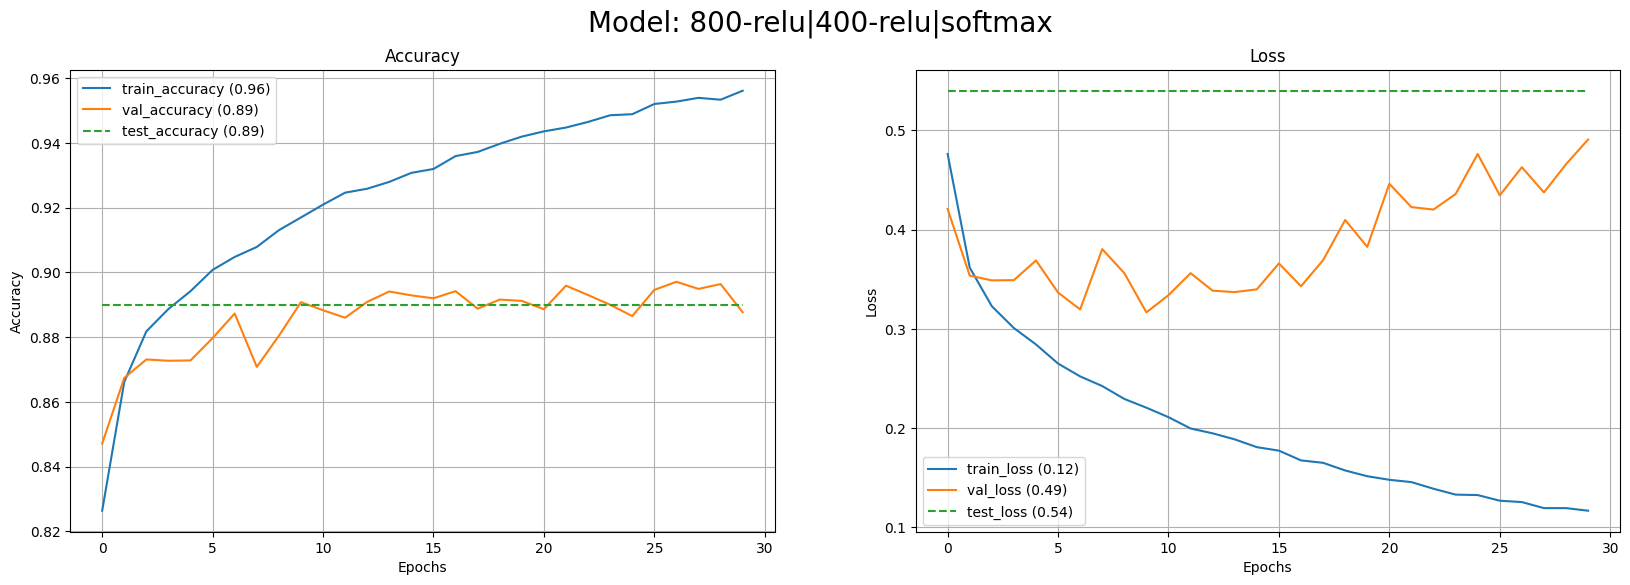

In [9]:
# experiment 1
model = Sequential()
model.add(Input(shape=(x_train.shape[1],)))
model.add(Dense(800, activation='relu')) 
model.add(Dense(400, activation='relu')) 
model.add(Dense(CLASS_COUNT, activation='softmax'))

result = compile_train_eval(model, '800-relu|400-relu|softmax')